<a href="https://colab.research.google.com/github/domdelvecchio/machine-learning-101/blob/main/titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TITANIC Survival Prediction Model

### Importing the libraries

In [590]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [591]:
tf.__version__

'2.4.0'

In [592]:
def _shuffle(list):
  c = plt.style.available
  random.shuffle(list)
  return list[0]

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

## Part 1 - Data Preprocessing

### Importing the dataset

In [593]:
#train and test dataset
# survival - Survival (0 = No; 1 = Yes)
# class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# name - Name
# sex - Sex
# age - Age
# sibsp - Number of Siblings/Spouses Aboard
# parch - Number of Parents/Children Aboard
# ticket - Ticket Number
# fare - Passenger Fare
# cabin - Cabin
# embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
url_train = 'https://raw.githubusercontent.com/domdelvecchio/machine-learning-101/main/titanic/train.csv'
url_test = 'https://raw.githubusercontent.com/domdelvecchio/machine-learning-101/main/titanic/test.csv'
ds_train = pd.read_csv(url_train)
ds_test = pd.read_csv(url_test)
# x_train = dataset.iloc[:, 2:].values
# y_train = dataset.iloc[:, 1].values

Stats on data

In [594]:
describe = ds_train.describe()
describe.index = describe.index.map(str.upper)
describe

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
COUNT,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
MEAN,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
STD,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
MIN,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
MAX,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Plot

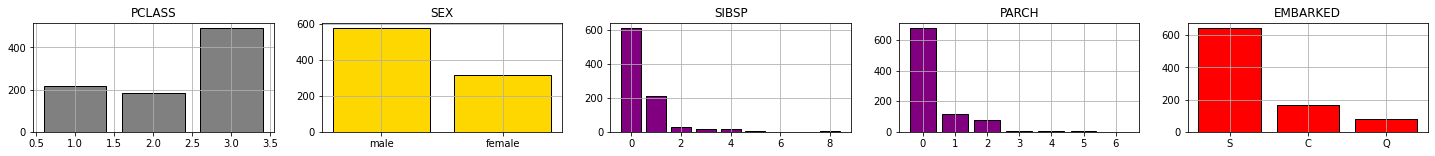

In [595]:
cats = ['Pclass','Sex','SibSp','Parch','Embarked']
fig,ax=plt.subplots(1,len(cats),figsize=(25,2))
colors =  ['blue','green','gray','gold','yellow', 'orange', 'red','purple','indigo','violet']
survived = ds_train[ds_train.Survived==1].Survived.value_counts()
for i,c in enumerate(cats):
  v = ds_train[c].value_counts() 
  ax[i].bar(v.index,v,color =_shuffle(colors),edgecolor='black')
  ax[i].set_title(c.upper())
  ax[i].set_ylabel('')
  ax[i].grid(True)
plt.show()

Check if there are NULL values

In [596]:
dfnulls = ds_train.isnull().sum()
dfnulls[dfnulls.values>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Replace NULL values (Data Imputation)

In [597]:
#cabin, replace null with 'Unknown
ds_train['Cabin'].fillna('Unknown',inplace=True)
#for Cabin we are only interested in the deck (first letter)
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
ds_train['Deck'] = ds_train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

#Embarked, only two NULL, fill with S since it is by farmost common
ds_train.Embarked.fillna('S',inplace=True)

# Age, replace nulls with average age
ds_train['Age'].fillna(value=ds_train['Age'].mean(), inplace=True)


Other data cleansing

In [598]:
# Create a column Title from Name
ds_train['Title'] = ds_train.Name.str.extract('([A-Za-z]+)\.')
ds_train['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
ds_train.drop(['PassengerId','Name','Ticket','Cabin','Fare','Title'], axis=1, inplace=True)
ds_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Deck
0,0,3,male,22.0,1,0,S,Unknown
1,1,1,female,38.0,1,0,C,C
2,1,3,female,26.0,0,0,S,Unknown
3,1,1,female,35.0,1,0,S,C
4,0,3,male,35.0,0,0,S,Unknown


Prepare X and Y data

In [599]:
x_train = ds_train.iloc[:, 1:].values
y_train = ds_train.iloc[:, 0].values

print(x_train)
print(y_train)

[[3 'male' 22.0 ... 0 'S' 'Unknown']
 [1 'female' 38.0 ... 0 'C' 'C']
 [3 'female' 26.0 ... 0 'S' 'Unknown']
 ...
 [3 'female' 29.69911764705882 ... 2 'S' 'Unknown']
 [1 'male' 26.0 ... 0 'C' 'C']
 [3 'male' 32.0 ... 0 'Q' 'Unknown']]
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 

In [600]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#label encode the Sex column (Male, Female) => (1,0)
x_train[:, 1] = le.fit_transform(x_train[:, 1])
print(x_train[0:5,:])

[[3 1 22.0 1 0 'S' 'Unknown']
 [1 0 38.0 1 0 'C' 'C']
 [3 0 26.0 0 0 'S' 'Unknown']
 [1 0 35.0 1 0 'S' 'C']
 [3 1 35.0 0 0 'S' 'Unknown']]


In [601]:
# One Hot Encoding the "Embark", "Deck" and "Gate" columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [5,6])], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))
x_train[0:5,:]

array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3, 1,
        22.0, 1, 0],
       [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0,
        38.0, 1, 0],
       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3, 0,
        26.0, 0, 0],
       [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0,
        35.0, 1, 0],
       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3, 1,
        35.0, 0, 0]], dtype=object)

In [602]:
x_train = np.asarray(x_train).astype(np.float32)

In [603]:
# Feature Scaling
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#x_train = sc.fit_transform(x_train)
#x_train[0:5,:]

Label output data 'g' and 'b'

# Prepare Test Data

In [604]:
#apply same transformation to test data
#train and test data should be prepared separately. However, it could be that for some transformations
#the test data might contain less values (e.g. for Deck). In this case, doing a fit and transform again
#on the test data would produce less columns on the test set and it cannot be used on the trained model
#We therefore keep the fit performed on the train data and only run transform on the test data

#cabin, replace null with 'Unknown
ds_test['Cabin'].fillna('Unknown',inplace=True)
#for Cabin we are only interested in the deck (first letter)
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
ds_test['Deck'] = ds_test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

#Embarked, only two NULL, fill with S since it is by farmost common
ds_test.Embarked.fillna('S',inplace=True)

# Age, replace nulls with average age
ds_test['Age'].fillna(value=ds_test['Age'].mean(), inplace=True)
#drop columns
ds_test.drop(['PassengerId','Name','Ticket','Cabin','Fare'], axis=1, inplace=True)
x_test = ds_test.values
#only do data transformation here (fit has already been done for train set)
x_test[:, 1] = le.transform(x_test[:, 1])
x_test = np.array(ct.transform(x_test))
x_test = np.asarray(x_test).astype(np.float32)

In [605]:
print(x_test.shape)
print(x_train.shape)

(418, 17)
(891, 17)


### Splitting the dataset into the Training set and Test set

In [606]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

## Part 2 - Building the ANN

### Initializing the ANN

In [607]:
ann = tf.keras.models.Sequential()

### Adding the input layer and the first hidden layer

In [608]:
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))

### Adding the second hidden layer

In [609]:
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))

### Adding the output layer

In [610]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the ANN

### Compiling the ANN

In [611]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Training the ANN model on the Training set

In [612]:
history = ann.fit(x_train, y_train, epochs=150, batch_size=4, validation_data=(x_val, y_val), verbose=0)

## Plot Accuracy

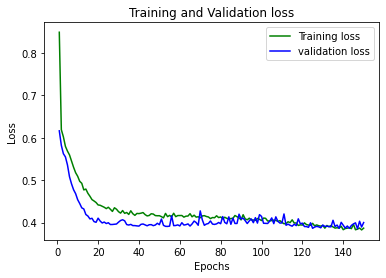

In [613]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

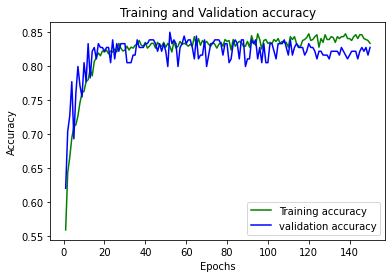

In [614]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_val) + 1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate test data

### Predicting the results of the Test set

In [ ]:
y_pred = ann.predict(x_test)
print(y_pred)